In [2]:
# IMPORTAÇÕES UTILIZADAS:
import geopandas as gpd
import pandas as pd
import json
import folium
import matplotlib.pyplot as plt

In [21]:
# CARREGA O GEOJSON, FAZ UM CHECK DAS CHAVES PRINCIPAIS, E MOSTRA A QUANTIDADE DE FEATURES:


geojson_path = "/content/dataset_projetoGeo.geojson"

with open(geojson_path, "r", encoding="utf-8") as f:
    flood_data = json.load(f)

print("Chaves principais:", flood_data.keys())
print("Número de features:", len(flood_data["features"]))


Chaves principais: dict_keys(['type', 'features'])
Número de features: 91


In [22]:
# CONVERTE PARA DATA FRAME:

gdf = gpd.GeoDataFrame.from_features(flood_data["features"])

print(gdf.head())


                                            geometry clear_perc clear_views  \
0  POLYGON ((-68.21301 -40.05027, -66.09706 -40.0...       None        None   
1  POLYGON ((-52.55678 -18.05951, -51.94452 -18.0...       None        None   
2  POLYGON ((-56.28879 -32.97154, -54.03149 -32.9...       None        None   
3  POLYGON ((-58.63149 -24.79301, -59.86071 -24.7...       None        None   
4  POLYGON ((-65.59765 12.46974, -67.67192 12.469...       None        None   

  duration flooded      id jrc_perm_water  
0     None    None  1810.0           None  
1     None    None  1885.0           None  
2     None    None  1925.0           None  
3     None    None  1939.0           None  
4     None    None  1996.0           None  


In [26]:
# VIZUALIZAR OS DADOS NO MAPA:

m = folium.Map(location=[-10, -55], zoom_start=4) # cordenadas que fazem carregar na america do sul

for _, row in gdf.iterrows():
    if row.geometry and not row.geometry.is_empty:
        centroid = row.geometry.centroid
        folium.Marker(
            location=[centroid.y, centroid.x],
            popup=f"Inundação: {row['flooded']}",
            icon=folium.Icon(color="blue")
        ).add_to(m)
m


In [33]:
# LIMPAR DADOS E PREENCHER EM TABELA:

gdf = gpd.read_file(geojson_path)

# rEmover nulos
gdf = gdf[gdf.geometry.notnull() & ~gdf.geometry.is_empty]

# Verificar a porcentagem de valores nulos por coluna
missing_values = gdf.isnull().sum()
missing_percentage = (missing_values / len(gdf)) * 100


missing_data_summary = pd.DataFrame({
    "Coluna": missing_values.index,
    "Valores Nulos": missing_values.values,
    "Porcentagem de Nulos (%)": missing_percentage.values
})

missing_data_summary = missing_data_summary.sort_values(by="Porcentagem de Nulos (%)", ascending=False) # Maior para o menor
print(missing_data_summary)

gdf_filtered = gdf[["id", "geometry"]] # Aqui só o id e o geometrysão importantes

gdf_filtered.head()


           Coluna  Valores Nulos  Porcentagem de Nulos (%)
0      clear_perc             91                     100.0
1     clear_views             91                     100.0
2        duration             91                     100.0
3         flooded             91                     100.0
5  jrc_perm_water             91                     100.0
4              id              0                       0.0
6        geometry              0                       0.0


,id,geometry
0,1810.0,"POLYGON ((-68.21301 -40.05027, -66.09706 -40.0..."
1,1885.0,"POLYGON ((-52.55678 -18.05951, -51.94452 -18.0..."
2,1925.0,"POLYGON ((-56.28879 -32.97154, -54.03149 -32.9..."
3,1939.0,"POLYGON ((-58.63149 -24.79301, -59.86071 -24.7..."
4,1996.0,"POLYGON ((-65.59765 12.46974, -67.67192 12.469..."


Nenhuma coluna de região encontrada. Apenas exibindo o total de eventos.
Total de eventos registrados: 91
Número total de eventos: 91
Tipos de geometrias presentes: ['Polygon']
Área média de inundação (km²): 0.00028040455639008585


<ipython-input-36-a056a50da7d0>:31: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["area_km2"] = gdf.geometry.area / 1e6  # Converter de metros quadrados para km²


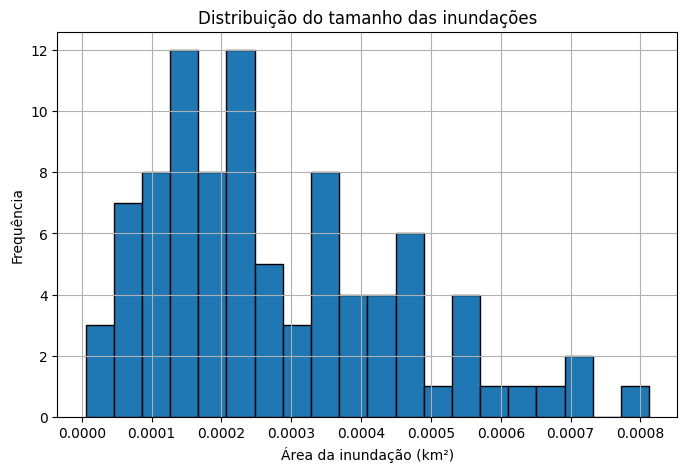

In [36]:
# ESTÁTISTICAS E VISUALIZAÇÕES:

m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4, tiles="OpenStreetMap")

for _, row in gdf_filtered.iterrows():
    if row.geometry.geom_type == "Point":
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            popup=f"ID: {row['id']}",
            icon=folium.Icon(color="blue")
        ).add_to(m)

m

if "region" in gdf.columns:
    flood_counts = gdf["region"].value_counts()
    print(flood_counts)
else:
    print("Nenhuma coluna de região encontrada. Apenas exibindo o total de eventos.")
    print(f"Total de eventos registrados: {len(gdf)}")

print("Número total de eventos:", len(gdf))
print("Tipos de geometrias presentes:", gdf.geometry.geom_type.unique())

if gdf.geometry.geom_type.isin(["Polygon", "MultiPolygon"]).any():
    gdf["area_km2"] = gdf.geometry.area / 1e6
    print("Área média de inundação (km²):", gdf["area_km2"].mean())

if "area_km2" in gdf.columns:
    plt.figure(figsize=(8, 5))
    gdf["area_km2"].hist(bins=20, edgecolor="black")
    plt.xlabel("Área da inundação (km²)")
    plt.ylabel("Frequência")
    plt.title("Distribuição do tamanho das inundações")
    plt.show()


In [ ]:
# CONCLUSÃO COM BASE NAS ANÁLISES:

'''
- O conjunto tem 91 eventos de inundação
- Essas colunas estão com 100% de seus valores nulos no dataset: clear_perc, clear_views, duration, flooded, jrc_perm_water
- Como as colunas sitadas são nulas, elas não ajudam em nada na análise

- Os eventos estão na america do sul, mas tem uma concentraçao maior no brasil
- No brasil, tem mais inundação no sul

'''